# 永續課程分類

執行方式:
- 基本上就是直接跑過整個檔案
- 要確定有 "課程SDG分類_20220610-v2.xlsx" 以及 "embedding_tensor.pt" 這兩個檔案，以及正確的 config 路徑設定
  (若是要重新計算所有文本的 Embedding，那就把 In [26] 的註解拿掉，這樣就不需要先有 "embedding_tensor.pt" 這個檔案也可以跑)

---

程式碼區塊提醒:

In [6] : 可以修改任務相關的 Config 設定 (e.g. 超參數、檔案路徑)

In [26]: 用來計算文本的 Embedding (如果有做新的前處理的話，就要把這個 Cell 的註解拿掉，重新跑一次計算 Embedding)

---

可能ㄉ優化方向:
- 額外前處理
- 調整文本的切割方式
- 更換 PLM
- 調整下游模型架構 or 超參數
- 調整類別權重
- 針對 SDG 各類別之間的關係建模 (大概看了一下發現有些類別好像很常一起出現)

---

目前問題:
- 目前是用 Validation Data 拿來當作 Test Data 評估最終結果，但似乎有失公正性
- 目前的評估方法不確定是否正確

## 載入套件

In [1]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [2]:
import gc
import math
import random
import statistics
from tqdm import tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kz7qc5ty because the default path (/home/emma/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 

from transformers import BertTokenizerFast, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
# config
config = {
    "file_path": "課程SDG分類_20220610-v2.xlsx",
    "embedding_path": "embedding_tensor.pt",
    "model_path": 'model.ckpt',
    "val_size": 0.3,
    "seed": 42,
    "max_chunk_size": 128,  # 一個 Chunk 的字數上限
    "max_chunk_num": 30,    # 一筆資料的 Chunk 數量上限 
    "learning_rate": 3e-4,  
    "batch_size": 64,
    "epochs": 200,
    "patience": 20,
}

In [7]:
# fix random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [8]:
set_seed(config["seed"])

/home/emma/bilab/kuokuo/kuokuo_env/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## 文本前處理

In [9]:
# 讀取資料
df_dirty = pd.read_excel(config["file_path"], engine='openpyxl')
print(df_dirty.shape)

######################## 移除 Rows ########################
# 移除整列都是空值的資料
df_dirty = df_dirty.dropna(axis=0, how='all')
print(df_dirty.shape)

# 移除服務學習、碩博士論文、專題研究
drop_values = ["服務學習", "專題研究", "碩士論文", "博士論文", "書報討論", "專題討論"]
for drop_value in drop_values:
    df_dirty = df_dirty[~df_dirty["課名"].str.contains(drop_value)]
print(df_dirty.shape)

# 移除課程資訊包含 "待補" 的課程
df_dirty = df_dirty[df_dirty["課程大綱課程概述"] != "待補"]
df_dirty = df_dirty[df_dirty["課程目標"] != "待補"]
print(df_dirty.shape)

######################## 移除 Cols ########################
# 移除不需要的欄位
drop_list = ["學年度-學期", "dpt_code", "學院", "系所", "班次", "tea_code", "授課教師", "課程要求"]
df_dirty = df_dirty.drop(drop_list, axis=1)

# 重設索引並查看資料表
df_clean = df_dirty.reset_index(drop=True)
df_clean.head(1)

(4257, 29)
(1502, 29)
(1289, 29)
(1182, 29)


,課程代號,課名,課程大綱課程概述,課程目標,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,...,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17
0,801 18000,公共衛生學,公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業...,修完此課程，期望同學將能夠：\n\n1.瞭解公共衛生的基本概念與重要內涵。\n\n2.瞭解台...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 加入合併欄位後的新欄位 Context
df_clean["context"] = df_clean.apply(lambda row: f"課名：{row.課名}$$$大綱：{row.課程大綱課程概述}$$$目標：{row.課程目標}", axis=1)

# 去除換行符號
df_clean["context"] = df_clean["context"].apply(lambda x: x.replace("\n", ""))

In [11]:
# Context 範例
df_clean["context"][0]

'課名：公共衛生學$$$大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業醫學、工業衛生、衛生政策、醫療管理、健康行為與衛生教育等層面。本課程的目的在於提供學習者對於公共衛生的一個鳥瞰圖，由宏觀的觀點切入，認識何謂公共衛生、公共衛生所涵括的內容、以及我國公共衛生的過去、現在及未來發展趨勢。$$$目標：修完此課程，期望同學將能夠：1.瞭解公共衛生的基本概念與重要內涵。2.瞭解台灣公共衛生的成就與面臨的挑戰。3.體會如何以基本公共衛生觀點來分析社會上發生的健康相關事件。'

In [12]:
def ChunkS(text, chunk_size):
    chunk_char = ["$$$", "一、", "二、", "三、", "四、", "五、", "六、", "(一)", "(二)", "(三)", "(四)", "(五)", "(六)", "1.", "2.", "3.", "4.", "5.", "6.", "。", "！", "？", "，", "、", "_", "END"]  # 自己加字符
    if len(text) <= chunk_size:
        return f'{text.strip()}'
    for cchar in chunk_char:
        cchar_len = len(cchar)
        i = text.rfind(cchar, 0, chunk_size)
        if i == -1:
            if cchar != "END":
                continue
            return f'{text[:chunk_size].strip()}<CHUNK>{ChunkS(text[chunk_size+1:], chunk_size)}'
        # 不同長度的切割字元，要給不同的切分位置
        if cchar_len == 1:  # 單個符號保留在前句(ex. 。)
            return f'{text[:i+1].strip()}<CHUNK>{ChunkS(text[i+1:], chunk_size)}'
        else:  # 多個符號保留在後句(ex. 1.)
            return f'{text[:i].strip()}<CHUNK>{cchar+ChunkS(text[i+cchar_len:], chunk_size)}'

def short_sentence(text, chunk_size):
    '''Chunking long document to multi short sentences, base on "。", "！", "？", "，" etc.'''
    return ChunkS(text, chunk_size).split("<CHUNK>")

In [13]:
# 將 Context 切分成多個短子句 Context chunk
df_clean["context_chunk"] = df_clean["context"].apply(short_sentence, chunk_size=config["max_chunk_size"])
# 移除分隔符號 ($$$)
df_clean["context_chunk"] = df_clean["context_chunk"].apply(lambda x: [c.strip("$$$") for c in x])
df_clean["context_chunk"] = df_clean["context_chunk"].apply(lambda x: [c.replace("$$$", "。") for c in x])

In [14]:
# Context Chunk 範例
for chunk in df_clean.loc[0, "context_chunk"]:
    print(chunk + "\n------------")

課名：公共衛生學
------------
大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業醫學、工業衛生、衛生政策、醫療管理、健康行為與衛生教育等層面。
------------
本課程的目的在於提供學習者對於公共衛生的一個鳥瞰圖，由宏觀的觀點切入，認識何謂公共衛生、公共衛生所涵括的內容、以及我國公共衛生的過去、現在及未來發展趨勢。
------------
目標：修完此課程，期望同學將能夠：1.瞭解公共衛生的基本概念與重要內涵。2.瞭解台灣公共衛生的成就與面臨的挑戰。3.體會如何以基本公共衛生觀點來分析社會上發生的健康相關事件。
------------


In [15]:
# 查看最終擁有的欄位
print(df_clean.columns.to_list())

['課程代號', '課名', '課程大綱課程概述', '課程目標', 'SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 'context', 'context_chunk']


課程大綱課程概述
Max count: 5573
Median count: 192.0
Quantiles count: [ 98. 432.]


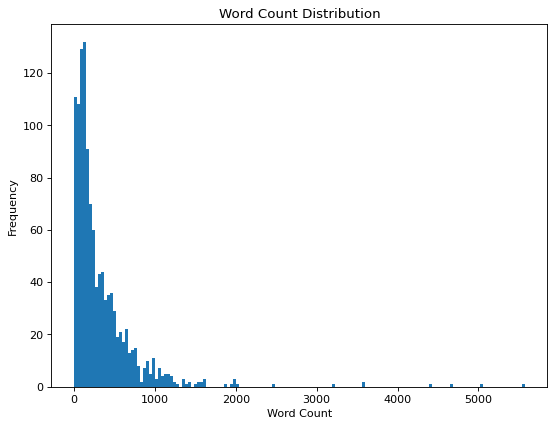

課程目標
Max count: 1722
Median count: 87.0
Quantiles count: [ 40.   179.75]


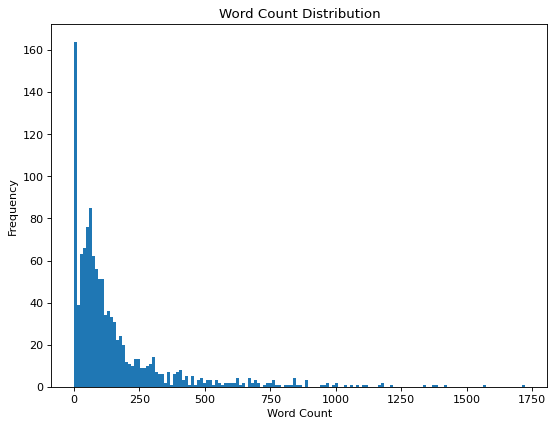

context
Max count: 5423
Median count: 349.5
Quantiles count: [198.25 623.5 ]


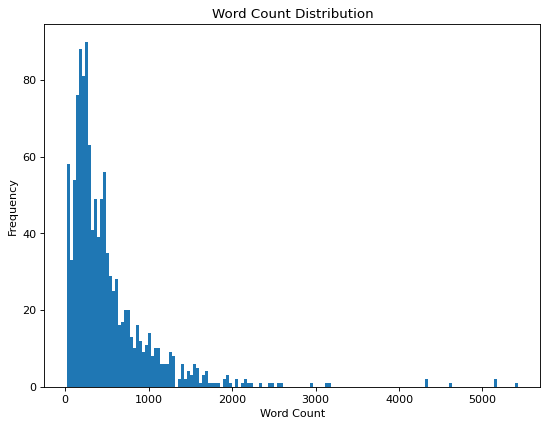

In [16]:
# 觀察重要欄位的字數分佈
column_list = ['課程大綱課程概述', '課程目標', "context"]
for col in column_list:  
    word_counts = [len(each) if type(each) == str else 0 for each in df_clean[col]]
    print(col)
    max_count = max(word_counts)
    median_count = statistics.median(word_counts)
    quantiles_count = np.quantile(word_counts, q = np.arange(0.25, 1, 0.5))
    print(f"Max count: {max_count}")
    print(f"Median count: {median_count}")
    print(f"Quantiles count: {quantiles_count}")
    plt.figure(figsize=(8, 6), dpi=80)
    n, bins, patches = plt.hist(word_counts, bins=150)
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.title(f"Word Count Distribution")
    plt.show()

Max count: 56
Mean count: 6


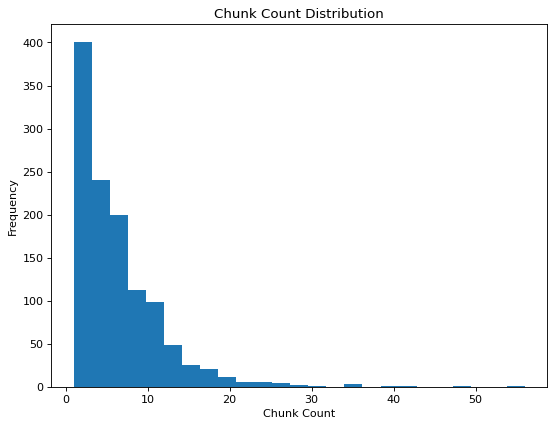

In [17]:
# 觀察短子句數量分佈
chunk_count = [len(context_chunk) for context_chunk in df_clean["context_chunk"]]
print(f"Max count: {max(chunk_count)}")
print(f"Mean count: {int(sum(chunk_count)/len(chunk_count))}")
plt.figure(figsize=(8, 6), dpi=80)
n, bins, patches = plt.hist(chunk_count, bins=25)
plt.xlabel("Chunk Count")
plt.ylabel("Frequency")
plt.title("Chunk Count Distribution")
plt.show()

## 切分訓練與驗證資料

In [18]:
# 類別標籤欄位清單 (SDG1~SDG17)
label_list = df_clean.columns[4:-2]
print(label_list)

# 切割訓練與驗證資料 (train_df, val_df)
train_df, val_df = train_test_split(df_clean, test_size=config["val_size"], random_state=config["seed"])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Index(['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9',
       'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17'],
      dtype='object')


In [19]:
# 訓練資料與驗證資料個類別的樣本數
print("訓練資料類別分佈:")
print([train_df[each].value_counts()[1.0] for each in label_list])
print("驗證資料類別分佈:")
print([val_df[each].value_counts()[1.0] for each in label_list])

訓練資料類別分佈:
[20, 22, 226, 300, 21, 25, 16, 182, 24, 39, 44, 48, 25, 36, 41, 23, 26]
驗證資料類別分佈:
[12, 10, 94, 115, 5, 9, 7, 66, 9, 15, 20, 21, 7, 7, 12, 15, 8]


In [20]:
train_df["context_chunk"][1]

['課名：生死學',
 '大綱：本課程藉由醫學及人文社會科學之不同理論、觀點與面向，針對「醫療與生死」進行廣泛的分析與探討，內容設計著重從理論與實務，強調學生的參與互動及深入思考，並安排與附設醫院安寧緩和醫療病房團隊進行討論。是本校醫學系人文、倫理與心理社會面向教育的總結。',
 '目標：幫助醫學生從倫理學、心理及精神醫學、法學、哲學、歷史學、東西方宗教、安寧緩和醫療等觀點，探討醫療工作中的生與死議題，期能幫助修課同學，在成為實習醫師前，對於個人的生死觀及面對醫療工作中的生命、死亡與醫療問題，有多一層的思考與認識。']

In [21]:
train_df["context_chunk"][2]

['課名：專題演講。大綱：專題演講。目標：廣邀不同背景的專家學者，為所上學生不管是求學或是日後職涯規劃，提供更開闊的思考空間。']

## 載入 BERT 模型

In [22]:
device = torch.device('cuda', 0) if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [23]:
# BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

# BERT Model
bert = AutoModel.from_pretrained('ckiplab/bert-base-chinese').to(device)

Some weights of the model checkpoint at ckiplab/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dens

## 計算 Chunk Embedding

In [24]:
# 先確保所有文章的 Chunk 數一致
context_chunk_lists = df_clean['context_chunk']
max_chunk_num = config["max_chunk_num"]
        
for i in range(len(context_chunk_lists)):
    text_len = len(context_chunk_lists[i])
    if text_len < max_chunk_num:
        tmp = [""] * (max_chunk_num - text_len)
        context_chunk_lists[i] += tmp
    else:
        context_chunk_lists[i] = context_chunk_lists[i][:max_chunk_num]

In [25]:
def get_embedding_tensor(context_chunk_lists, max_chunk_num, max_chunk_size):
    embedding_tensor = torch.ones((len(context_chunk_lists), max_chunk_num, 768))
    count = 0
    for i in range(len(context_chunk_lists)):
        context_chunk_list = context_chunk_lists[i]
        embedding = []
        for chunk in context_chunk_list:
            bert_input = tokenizer(chunk, padding='max_length', max_length=max_chunk_size,
                            truncation=True, return_tensors="pt")
            attention_mask = bert_input['attention_mask'].to(device)
            input_id = bert_input['input_ids'].squeeze(1).to(device)
            final_inputs = {'input_ids': input_id, 'attention_mask': attention_mask}
            outputs = bert(**final_inputs)
            # 因為 CLS 外面接的 Layer 存在 Random，因此每次跑出來結果會不一樣
            # pooler_output = outputs.pooler_output.reshape(768)  # torch.Size([1, 768]) -> torch.Size([768])
            # 要改成這樣寫才可以
            pooler_output = outputs.last_hidden_state[0][0].reshape(768)
            embedding.append(pooler_output)
        embedding = torch.stack(embedding).detach().cpu()  # torch.Size([n, 768])
        count += 1
        print(f"Finish: {count}/{len(context_chunk_lists)}")
        print(embedding)
        embedding_tensor[i] = embedding
        gc.collect()
        torch.cuda.empty_cache()
    return embedding_tensor

In [26]:
# # 如果要計算新的 Embedding 的話，就把這個 cell 的註解拿掉

# # 計算每個樣本各自的 BERT Embedding
# embedding_tensor = get_embedding_tensor(context_chunk_lists, config["max_chunk_num"], config["max_chunk_size"])

# # 儲存 BERT Embedding Tensor
# torch.save(embedding_tensor, config["embedding_path"])

## 載入 Chunk Embedding

In [27]:
# 載入 BERT Embedding Tensor
embedding_tensor = torch.load(config["embedding_path"])

In [28]:
print(type(embedding_tensor))
print(embedding_tensor.shape)

<class 'torch.Tensor'>
torch.Size([1182, 30, 768])


In [29]:
# 切割訓練與驗證 Embedding (train_embedding, val_embedding)
train_embedding, val_embedding = train_test_split(embedding_tensor, test_size=config["val_size"], random_state=config["seed"])

## 定義函數

In [30]:
# 函數: 計算 Class weight

def get_class_weight(df, labels):
    # 計算每個類別的「正樣本數量」，儲存成 class_pos_count 列表
    class_pos_count = np.zeros(len(labels))
    # 計算每個類別的「負樣本數量」，儲存成 class_neg_count 列表
    class_neg_count = np.zeros(len(labels))
    # 遞迴
    for i in range(len(labels)):
        label = labels[i]
        positive, negative = df[label].value_counts()[1.0], df[label].value_counts()[0.0]
        class_pos_count[i], class_neg_count[i] = positive, negative
    # 計算「正樣本權重」
    class_pos_weight = np.ones_like(class_pos_count)
    for cdx, (pos_count, neg_count) in enumerate(zip(class_pos_count, class_neg_count)):
        class_pos_weight[cdx] = math.sqrt(neg_count/(pos_count+1e-5))
    return torch.as_tensor(class_pos_weight, dtype=torch.float)

In [31]:
# 函數: 計算 Accuracy, Precision, Recall, Top-k

def _ACCscore(y_true, pred):
    accuracy_l = [ans.all() for ans in (pred == y_true)]
    accuracy = np.array(accuracy_l).mean()
    return accuracy


def _PRscore(y_true, pred):
    hit_matrix = np.zeros_like(pred)
    hit_matrix[np.where((pred == y_true) & (y_true > 0))] = 1
    tp = hit_matrix.sum(axis=1)
    pred_sum = pred.sum(axis=1)
    true_sum = y_true.sum(axis=1)
    precision_l = []
    recall_l = []
    for ix in range(tp.shape[0]):
        precision_score = (1.0 if true_sum[ix] == 0 else 0.0) if pred_sum[ix] == 0 else tp[ix]/pred_sum[ix]
        recall_score = (1.0 if pred_sum[ix] == 0 else 0.0) if true_sum[ix] == 0 else tp[ix]/true_sum[ix]
        precision_l.append(precision_score)
        recall_l.append(recall_score)
    precision = np.array(precision_l).mean()
    recall = np.array(recall_l).mean()
    return precision, recall


def _TopKscore(y_true, pred, output, k):
    topk_class = np.argsort(output, axis=1)[:,-k:]
    topk_pred = torch.zeros_like(pred)
    for i in range(pred.shape[0]):
        if pred[i, :].sum() > 0:
            topk_pred[i, topk_class[i]] = 1
    topk_precision, topk_recall = _PRscore(y_true, topk_pred)
    return topk_precision, topk_recall

In [32]:
# 函數: 一次同時計算所有評估指標

def score(y_true, pred, output, k=5):
    accuracy = _ACCscore(y_true, pred)
    precision, recall = _PRscore(y_true, pred)
    _, topk_recall = _TopKscore(y_true, pred, output, k)
    return accuracy, precision, recall, topk_recall

In [33]:
# 函數: 計算 F1-score

def f1(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

## 類別與權重資訊

In [34]:
# Class (Pos) Weight
class_weight = get_class_weight(train_df, label_list)

In [35]:
print("<< 目標變數與權重對應 >>\n")

print(f"<< 目標變數共有 {len(label_list)} 類 >>\n")

for c, w in zip(label_list, class_weight):
    print(f"{c}: {round(float(w), 2)}")

<< 目標變數與權重對應 >>

<< 目標變數共有 17 類 >>

SDG1: 6.35
SDG2: 6.05
SDG3: 1.63
SDG4: 1.33
SDG5: 6.2
SDG6: 5.66
SDG7: 7.12
SDG8: 1.88
SDG9: 5.78
SDG10: 4.5
SDG11: 4.22
SDG12: 4.03
SDG13: 5.66
SDG14: 4.69
SDG15: 4.38
SDG16: 5.91
SDG17: 5.55


## 訓練模型

In [36]:
class SDG_Dataset(Dataset):
    def __init__(self, df, embeddings, label_list):
        self.embeddings = embeddings
        self.labels = df[label_list].to_numpy()  # [[0,0,1], [0,1,1]...]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [37]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.lstm = nn.LSTM(768, 256, batch_first=True, bidirectional=False, dropout=0.)
        self.linear_1 = nn.Linear(256, 64)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(64, 17)

    def forward(self, embeddings):
        _, (ht, ct) = self.lstm(embeddings)
        output = self.linear_1(ht[-1])
        output = self.relu(output)
        output = self.linear_2(output)
        return output

In [38]:
def train(model, class_weight):
    # 記錄 train 訓練過程
    train_loss_list = []
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    train_topk_recall_list = []
    
    # 記錄 validation 訓練過程
    val_loss_list = []
    val_accuracy_list = []
    val_precision_list = []
    val_recall_list = []
    val_topk_recall_list = []
    
    # Training and Val Dataset
    train_set = SDG_Dataset(train_df, train_embedding, label_list)
    val_set = SDG_Dataset(val_df, val_embedding, label_list)

    train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=False)

    # Loss Function
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])

    # 把模型放到 GPU 上跑
    model = model.to(device)
    criterion = criterion.to(device)
    
    # 將模型設定成「訓練」狀態（Dropout等Layer才會被觸發）
    model.train()

    # Early Stopping
    trigger_times = 0
    best_f1 = 0.0
    
    # 訓練階段
    epochs = config["epochs"]
    for epoch_num in range(epochs):
        
        # 訓練並儲存訓練結果
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        topk_recall_list = []

        for train_embeddings, train_labels in tqdm(train_loader):
    
            optimizer.zero_grad()
            
            train_embeddings = train_embeddings.to(device)
            train_labels = train_labels.to(device)

            output = model(train_embeddings)

            batch_loss = criterion(output, train_labels.float())
            
            # Back propagation
            batch_loss.backward()
            optimizer.step()
            
            output = output.cpu().detach()
            pred = (output > 0).cpu()
            y_true = (train_labels > 0).cpu()
        
            # 計算 batch 表現並存起來
            loss = batch_loss.item()
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            
            loss_list.append(loss)
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)
        
        # 計算 EPOCH 表現並存起來
        train_loss = np.array(loss_list).mean()
        train_accuracy = np.array(accuracy_list).mean()
        train_precision = np.array(precision_list).mean()
        train_recall = np.array(recall_list).mean()
        train_topk_recall = np.array(topk_recall_list).mean()
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_topk_recall_list.append(train_topk_recall)
        
        # F1-score
        train_f1 = f1(train_precision, train_recall)

        # ===============================================================================
        
        # 驗證並儲存驗證結果
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        topk_recall_list = []
        
        # 驗證當下的模型表現
        with torch.no_grad():
            for val_embeddings, val_labels in tqdm(val_loader):

                val_embeddings = val_embeddings.to(device)
                val_labels = val_labels.to(device)

                output = model(val_embeddings)
                
                batch_loss = criterion(output, val_labels.float())
                
                output = output.cpu()
                pred = (output > 0).cpu()
                y_true = (val_labels > 0).cpu()
                
                # 計算 batch 表現並存起來
                loss = batch_loss.item()
                accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
                
                loss_list.append(loss)
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                topk_recall_list.append(topk_recall)
            
            # 計算 EPOCH 表現並存起來
            val_loss = np.array(loss_list).mean()
            val_accuracy = np.array(accuracy_list).mean()
            val_precision = np.array(precision_list).mean()
            val_recall = np.array(recall_list).mean()
            val_topk_recall = np.array(topk_recall_list).mean()
            
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            val_precision_list.append(val_precision)
            val_recall_list.append(val_recall)
            val_topk_recall_list.append(val_topk_recall)
            
            # F1-score
            val_f1 = f1(val_precision, val_recall)
        
        # 印出每一個 Epoch 的結果
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} \
            | Train F1: {train_f1: .3f} \
            | Val Loss: {val_loss: .3f} \
            | Val F1: {val_f1: .3f}')
        
        # Early Stopping
        if val_f1 <= best_f1:
            trigger_times += 1
            print('Trigger times:', trigger_times)
            if trigger_times > config["patience"]:
                print('Early stopping!')
                break
        else:
            trigger_times = 0
            print('Trigger times:', trigger_times)
            best_f1 = val_f1
            torch.save(model.state_dict(), config["model_path"])
        
    return model, train_loss_list, train_precision_list, train_recall_list, \
                            val_loss_list, val_precision_list, val_recall_list

In [39]:
model = Classifier()
print(model)

Classifier(
  (lstm): LSTM(768, 256, batch_first=True)
  (linear_1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=64, out_features=17, bias=True)
)


In [40]:
model, train_loss_list, train_precision_list, train_recall_list, \
    val_loss_list, val_precision_list, val_recall_list = train(model, class_weight)

100%|██████████| 6/6 [00:00<00:00, 14.80it/s]


Epochs: 1 | Train Loss:  0.727             | Train F1:  0.101             | Val Loss:  0.646             | Val F1:  0.092
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.03it/s]


Epochs: 2 | Train Loss:  0.624             | Train F1:  0.118             | Val Loss:  0.566             | Val F1:  0.382
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.59it/s]


Epochs: 3 | Train Loss:  0.573             | Train F1:  0.362             | Val Loss:  0.529             | Val F1:  0.382
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.37it/s]


Epochs: 4 | Train Loss:  0.555             | Train F1:  0.361             | Val Loss:  0.519             | Val F1:  0.382
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.83it/s]


Epochs: 5 | Train Loss:  0.550             | Train F1:  0.362             | Val Loss:  0.517             | Val F1:  0.382
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.91it/s]


Epochs: 6 | Train Loss:  0.548             | Train F1:  0.362             | Val Loss:  0.517             | Val F1:  0.382
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 14.94it/s]


Epochs: 7 | Train Loss:  0.547             | Train F1:  0.362             | Val Loss:  0.517             | Val F1:  0.382
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 15.23it/s]


Epochs: 8 | Train Loss:  0.547             | Train F1:  0.362             | Val Loss:  0.517             | Val F1:  0.382
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 15.14it/s]


Epochs: 9 | Train Loss:  0.548             | Train F1:  0.361             | Val Loss:  0.516             | Val F1:  0.382
Trigger times: 7


100%|██████████| 6/6 [00:00<00:00, 14.41it/s]


Epochs: 10 | Train Loss:  0.547             | Train F1:  0.361             | Val Loss:  0.517             | Val F1:  0.382
Trigger times: 8


100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


Epochs: 11 | Train Loss:  0.548             | Train F1:  0.363             | Val Loss:  0.517             | Val F1:  0.382
Trigger times: 9


100%|██████████| 6/6 [00:00<00:00, 16.00it/s]


Epochs: 12 | Train Loss:  0.546             | Train F1:  0.363             | Val Loss:  0.516             | Val F1:  0.382
Trigger times: 10


100%|██████████| 6/6 [00:00<00:00, 14.28it/s]


Epochs: 13 | Train Loss:  0.546             | Train F1:  0.362             | Val Loss:  0.515             | Val F1:  0.382
Trigger times: 11


100%|██████████| 6/6 [00:00<00:00, 14.70it/s]


Epochs: 14 | Train Loss:  0.545             | Train F1:  0.362             | Val Loss:  0.514             | Val F1:  0.382
Trigger times: 12


100%|██████████| 6/6 [00:00<00:00, 14.29it/s]


Epochs: 15 | Train Loss:  0.544             | Train F1:  0.363             | Val Loss:  0.513             | Val F1:  0.382
Trigger times: 13


100%|██████████| 6/6 [00:00<00:00, 15.07it/s]


Epochs: 16 | Train Loss:  0.541             | Train F1:  0.362             | Val Loss:  0.510             | Val F1:  0.382
Trigger times: 14


100%|██████████| 6/6 [00:00<00:00, 15.18it/s]


Epochs: 17 | Train Loss:  0.539             | Train F1:  0.362             | Val Loss:  0.507             | Val F1:  0.382
Trigger times: 15


100%|██████████| 6/6 [00:00<00:00, 13.36it/s]


Epochs: 18 | Train Loss:  0.535             | Train F1:  0.363             | Val Loss:  0.505             | Val F1:  0.382
Trigger times: 16


100%|██████████| 6/6 [00:00<00:00, 14.60it/s]


Epochs: 19 | Train Loss:  0.530             | Train F1:  0.362             | Val Loss:  0.495             | Val F1:  0.382
Trigger times: 17


100%|██████████| 6/6 [00:00<00:00, 15.19it/s]


Epochs: 20 | Train Loss:  0.516             | Train F1:  0.362             | Val Loss:  0.480             | Val F1:  0.382
Trigger times: 18


100%|██████████| 6/6 [00:00<00:00, 16.11it/s]


Epochs: 21 | Train Loss:  0.491             | Train F1:  0.363             | Val Loss:  0.458             | Val F1:  0.382
Trigger times: 19


100%|██████████| 6/6 [00:00<00:00, 15.30it/s]


Epochs: 22 | Train Loss:  0.470             | Train F1:  0.363             | Val Loss:  0.452             | Val F1:  0.382
Trigger times: 20


100%|██████████| 6/6 [00:00<00:00, 15.37it/s]


Epochs: 23 | Train Loss:  0.456             | Train F1:  0.368             | Val Loss:  0.441             | Val F1:  0.386
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.25it/s]


Epochs: 24 | Train Loss:  0.447             | Train F1:  0.366             | Val Loss:  0.442             | Val F1:  0.372
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.37it/s]


Epochs: 25 | Train Loss:  0.438             | Train F1:  0.375             | Val Loss:  0.432             | Val F1:  0.388
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.67it/s]


Epochs: 26 | Train Loss:  0.432             | Train F1:  0.390             | Val Loss:  0.428             | Val F1:  0.408
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.06it/s]


Epochs: 27 | Train Loss:  0.425             | Train F1:  0.395             | Val Loss:  0.417             | Val F1:  0.399
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.51it/s]


Epochs: 28 | Train Loss:  0.420             | Train F1:  0.389             | Val Loss:  0.430             | Val F1:  0.360
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


Epochs: 29 | Train Loss:  0.417             | Train F1:  0.387             | Val Loss:  0.410             | Val F1:  0.417
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.21it/s]


Epochs: 30 | Train Loss:  0.418             | Train F1:  0.396             | Val Loss:  0.414             | Val F1:  0.415
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 16.09it/s]


Epochs: 31 | Train Loss:  0.409             | Train F1:  0.404             | Val Loss:  0.411             | Val F1:  0.433
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.06it/s]


Epochs: 32 | Train Loss:  0.405             | Train F1:  0.439             | Val Loss:  0.412             | Val F1:  0.448
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.31it/s]


Epochs: 33 | Train Loss:  0.406             | Train F1:  0.439             | Val Loss:  0.411             | Val F1:  0.485
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 13.99it/s]


Epochs: 34 | Train Loss:  0.395             | Train F1:  0.473             | Val Loss:  0.399             | Val F1:  0.449
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.96it/s]


Epochs: 35 | Train Loss:  0.391             | Train F1:  0.494             | Val Loss:  0.395             | Val F1:  0.498
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.14it/s]


Epochs: 36 | Train Loss:  0.381             | Train F1:  0.542             | Val Loss:  0.392             | Val F1:  0.500
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.38it/s]


Epochs: 37 | Train Loss:  0.381             | Train F1:  0.548             | Val Loss:  0.392             | Val F1:  0.509
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.85it/s]


Epochs: 38 | Train Loss:  0.376             | Train F1:  0.543             | Val Loss:  0.379             | Val F1:  0.553
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.40it/s]


Epochs: 39 | Train Loss:  0.363             | Train F1:  0.574             | Val Loss:  0.392             | Val F1:  0.591
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.93it/s]


Epochs: 40 | Train Loss:  0.350             | Train F1:  0.600             | Val Loss:  0.373             | Val F1:  0.587
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.91it/s]


Epochs: 41 | Train Loss:  0.342             | Train F1:  0.611             | Val Loss:  0.378             | Val F1:  0.592
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.13it/s]


Epochs: 42 | Train Loss:  0.327             | Train F1:  0.604             | Val Loss:  0.387             | Val F1:  0.592
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.22it/s]


Epochs: 43 | Train Loss:  0.319             | Train F1:  0.632             | Val Loss:  0.381             | Val F1:  0.611
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.64it/s]


Epochs: 44 | Train Loss:  0.307             | Train F1:  0.631             | Val Loss:  0.358             | Val F1:  0.560
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.10it/s]


Epochs: 45 | Train Loss:  0.297             | Train F1:  0.637             | Val Loss:  0.367             | Val F1:  0.617
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.09it/s]


Epochs: 46 | Train Loss:  0.288             | Train F1:  0.661             | Val Loss:  0.352             | Val F1:  0.608
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.60it/s]


Epochs: 47 | Train Loss:  0.279             | Train F1:  0.669             | Val Loss:  0.352             | Val F1:  0.601
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.84it/s]


Epochs: 48 | Train Loss:  0.279             | Train F1:  0.658             | Val Loss:  0.408             | Val F1:  0.593
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 15.01it/s]


Epochs: 49 | Train Loss:  0.284             | Train F1:  0.663             | Val Loss:  0.362             | Val F1:  0.603
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 14.96it/s]


Epochs: 50 | Train Loss:  0.264             | Train F1:  0.666             | Val Loss:  0.353             | Val F1:  0.623
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.54it/s]


Epochs: 51 | Train Loss:  0.257             | Train F1:  0.682             | Val Loss:  0.332             | Val F1:  0.644
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.67it/s]


Epochs: 52 | Train Loss:  0.249             | Train F1:  0.691             | Val Loss:  0.325             | Val F1:  0.616
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


Epochs: 53 | Train Loss:  0.237             | Train F1:  0.691             | Val Loss:  0.346             | Val F1:  0.643
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.49it/s]


Epochs: 54 | Train Loss:  0.232             | Train F1:  0.717             | Val Loss:  0.338             | Val F1:  0.642
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.44it/s]


Epochs: 55 | Train Loss:  0.226             | Train F1:  0.731             | Val Loss:  0.350             | Val F1:  0.655
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.98it/s]


Epochs: 56 | Train Loss:  0.223             | Train F1:  0.732             | Val Loss:  0.361             | Val F1:  0.648
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.14it/s]


Epochs: 57 | Train Loss:  0.216             | Train F1:  0.731             | Val Loss:  0.369             | Val F1:  0.662
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.22it/s]


Epochs: 58 | Train Loss:  0.213             | Train F1:  0.751             | Val Loss:  0.363             | Val F1:  0.660
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.25it/s]


Epochs: 59 | Train Loss:  0.206             | Train F1:  0.766             | Val Loss:  0.343             | Val F1:  0.643
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.12it/s]


Epochs: 60 | Train Loss:  0.203             | Train F1:  0.762             | Val Loss:  0.365             | Val F1:  0.678
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.13it/s]


Epochs: 61 | Train Loss:  0.198             | Train F1:  0.775             | Val Loss:  0.334             | Val F1:  0.693
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.44it/s]


Epochs: 62 | Train Loss:  0.194             | Train F1:  0.784             | Val Loss:  0.354             | Val F1:  0.695
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.29it/s]


Epochs: 63 | Train Loss:  0.196             | Train F1:  0.774             | Val Loss:  0.356             | Val F1:  0.689
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 16.01it/s]


Epochs: 64 | Train Loss:  0.187             | Train F1:  0.797             | Val Loss:  0.330             | Val F1:  0.692
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.73it/s]


Epochs: 65 | Train Loss:  0.180             | Train F1:  0.799             | Val Loss:  0.362             | Val F1:  0.695
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.84it/s]


Epochs: 66 | Train Loss:  0.173             | Train F1:  0.808             | Val Loss:  0.366             | Val F1:  0.703
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.60it/s]


Epochs: 67 | Train Loss:  0.169             | Train F1:  0.827             | Val Loss:  0.342             | Val F1:  0.718
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.89it/s]


Epochs: 68 | Train Loss:  0.164             | Train F1:  0.824             | Val Loss:  0.372             | Val F1:  0.699
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.99it/s]


Epochs: 69 | Train Loss:  0.161             | Train F1:  0.838             | Val Loss:  0.359             | Val F1:  0.711
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.71it/s]


Epochs: 70 | Train Loss:  0.154             | Train F1:  0.844             | Val Loss:  0.373             | Val F1:  0.706
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.67it/s]


Epochs: 71 | Train Loss:  0.151             | Train F1:  0.853             | Val Loss:  0.380             | Val F1:  0.682
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 14.47it/s]


Epochs: 72 | Train Loss:  0.150             | Train F1:  0.848             | Val Loss:  0.376             | Val F1:  0.669
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 15.82it/s]


Epochs: 73 | Train Loss:  0.149             | Train F1:  0.864             | Val Loss:  0.351             | Val F1:  0.696
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 15.44it/s]


Epochs: 74 | Train Loss:  0.144             | Train F1:  0.858             | Val Loss:  0.354             | Val F1:  0.725
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.14it/s]


Epochs: 75 | Train Loss:  0.137             | Train F1:  0.871             | Val Loss:  0.387             | Val F1:  0.709
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.95it/s]


Epochs: 76 | Train Loss:  0.134             | Train F1:  0.871             | Val Loss:  0.410             | Val F1:  0.722
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.17it/s]


Epochs: 77 | Train Loss:  0.130             | Train F1:  0.886             | Val Loss:  0.381             | Val F1:  0.713
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.14it/s]


Epochs: 78 | Train Loss:  0.125             | Train F1:  0.895             | Val Loss:  0.409             | Val F1:  0.714
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


Epochs: 79 | Train Loss:  0.121             | Train F1:  0.898             | Val Loss:  0.406             | Val F1:  0.726
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.81it/s]


Epochs: 80 | Train Loss:  0.121             | Train F1:  0.907             | Val Loss:  0.412             | Val F1:  0.721
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


Epochs: 81 | Train Loss:  0.117             | Train F1:  0.897             | Val Loss:  0.425             | Val F1:  0.722
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.31it/s]


Epochs: 82 | Train Loss:  0.117             | Train F1:  0.898             | Val Loss:  0.449             | Val F1:  0.719
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.03it/s]


Epochs: 83 | Train Loss:  0.116             | Train F1:  0.910             | Val Loss:  0.376             | Val F1:  0.729
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


Epochs: 84 | Train Loss:  0.113             | Train F1:  0.906             | Val Loss:  0.396             | Val F1:  0.721
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.85it/s]


Epochs: 85 | Train Loss:  0.109             | Train F1:  0.909             | Val Loss:  0.368             | Val F1:  0.723
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.46it/s]


Epochs: 86 | Train Loss:  0.108             | Train F1:  0.917             | Val Loss:  0.450             | Val F1:  0.735
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.37it/s]


Epochs: 87 | Train Loss:  0.110             | Train F1:  0.910             | Val Loss:  0.316             | Val F1:  0.677
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.84it/s]


Epochs: 88 | Train Loss:  0.124             | Train F1:  0.895             | Val Loss:  0.399             | Val F1:  0.717
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 16.08it/s]


Epochs: 89 | Train Loss:  0.114             | Train F1:  0.896             | Val Loss:  0.406             | Val F1:  0.720
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 15.50it/s]


Epochs: 90 | Train Loss:  0.107             | Train F1:  0.908             | Val Loss:  0.455             | Val F1:  0.732
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 15.50it/s]


Epochs: 91 | Train Loss:  0.098             | Train F1:  0.926             | Val Loss:  0.459             | Val F1:  0.720
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 15.10it/s]


Epochs: 92 | Train Loss:  0.092             | Train F1:  0.935             | Val Loss:  0.438             | Val F1:  0.735
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.90it/s]


Epochs: 93 | Train Loss:  0.088             | Train F1:  0.936             | Val Loss:  0.459             | Val F1:  0.733
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


Epochs: 94 | Train Loss:  0.085             | Train F1:  0.944             | Val Loss:  0.390             | Val F1:  0.722
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.77it/s]


Epochs: 95 | Train Loss:  0.085             | Train F1:  0.936             | Val Loss:  0.432             | Val F1:  0.707
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 16.06it/s]


Epochs: 96 | Train Loss:  0.081             | Train F1:  0.941             | Val Loss:  0.468             | Val F1:  0.729
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 15.19it/s]


Epochs: 97 | Train Loss:  0.079             | Train F1:  0.950             | Val Loss:  0.449             | Val F1:  0.732
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 13.76it/s]


Epochs: 98 | Train Loss:  0.075             | Train F1:  0.953             | Val Loss:  0.468             | Val F1:  0.728
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 15.72it/s]


Epochs: 99 | Train Loss:  0.073             | Train F1:  0.956             | Val Loss:  0.442             | Val F1:  0.725
Trigger times: 7


100%|██████████| 6/6 [00:00<00:00, 15.98it/s]


Epochs: 100 | Train Loss:  0.073             | Train F1:  0.946             | Val Loss:  0.466             | Val F1:  0.719
Trigger times: 8


100%|██████████| 6/6 [00:00<00:00, 14.93it/s]


Epochs: 101 | Train Loss:  0.075             | Train F1:  0.934             | Val Loss:  0.558             | Val F1:  0.737
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 13.77it/s]


Epochs: 102 | Train Loss:  0.072             | Train F1:  0.942             | Val Loss:  0.525             | Val F1:  0.726
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.34it/s]


Epochs: 103 | Train Loss:  0.070             | Train F1:  0.949             | Val Loss:  0.485             | Val F1:  0.734
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 15.04it/s]


Epochs: 104 | Train Loss:  0.065             | Train F1:  0.960             | Val Loss:  0.483             | Val F1:  0.729
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 15.70it/s]


Epochs: 105 | Train Loss:  0.062             | Train F1:  0.964             | Val Loss:  0.478             | Val F1:  0.738
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.25it/s]


Epochs: 106 | Train Loss:  0.060             | Train F1:  0.965             | Val Loss:  0.560             | Val F1:  0.737
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.52it/s]


Epochs: 107 | Train Loss:  0.058             | Train F1:  0.967             | Val Loss:  0.539             | Val F1:  0.732
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 13.89it/s]


Epochs: 108 | Train Loss:  0.055             | Train F1:  0.965             | Val Loss:  0.545             | Val F1:  0.742
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 16.32it/s]


Epochs: 109 | Train Loss:  0.054             | Train F1:  0.967             | Val Loss:  0.553             | Val F1:  0.729
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.11it/s]


Epochs: 110 | Train Loss:  0.052             | Train F1:  0.970             | Val Loss:  0.540             | Val F1:  0.740
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.28it/s]


Epochs: 111 | Train Loss:  0.050             | Train F1:  0.971             | Val Loss:  0.537             | Val F1:  0.726
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 14.72it/s]


Epochs: 112 | Train Loss:  0.049             | Train F1:  0.973             | Val Loss:  0.534             | Val F1:  0.747
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


Epochs: 113 | Train Loss:  0.048             | Train F1:  0.972             | Val Loss:  0.540             | Val F1:  0.735
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 15.12it/s]


Epochs: 114 | Train Loss:  0.048             | Train F1:  0.971             | Val Loss:  0.528             | Val F1:  0.741
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.88it/s]


Epochs: 115 | Train Loss:  0.047             | Train F1:  0.973             | Val Loss:  0.588             | Val F1:  0.745
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 15.17it/s]


Epochs: 116 | Train Loss:  0.047             | Train F1:  0.973             | Val Loss:  0.573             | Val F1:  0.738
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


Epochs: 117 | Train Loss:  0.045             | Train F1:  0.976             | Val Loss:  0.554             | Val F1:  0.744
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 15.55it/s]


Epochs: 118 | Train Loss:  0.046             | Train F1:  0.973             | Val Loss:  0.540             | Val F1:  0.726
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 14.62it/s]


Epochs: 119 | Train Loss:  0.047             | Train F1:  0.970             | Val Loss:  0.527             | Val F1:  0.724
Trigger times: 7


100%|██████████| 6/6 [00:00<00:00, 14.70it/s]


Epochs: 120 | Train Loss:  0.044             | Train F1:  0.975             | Val Loss:  0.522             | Val F1:  0.724
Trigger times: 8


100%|██████████| 6/6 [00:00<00:00, 14.73it/s]


Epochs: 121 | Train Loss:  0.041             | Train F1:  0.980             | Val Loss:  0.555             | Val F1:  0.727
Trigger times: 9


100%|██████████| 6/6 [00:00<00:00, 14.85it/s]


Epochs: 122 | Train Loss:  0.041             | Train F1:  0.971             | Val Loss:  0.539             | Val F1:  0.716
Trigger times: 10


100%|██████████| 6/6 [00:00<00:00, 15.36it/s]


Epochs: 123 | Train Loss:  0.042             | Train F1:  0.966             | Val Loss:  0.539             | Val F1:  0.729
Trigger times: 11


100%|██████████| 6/6 [00:00<00:00, 15.16it/s]


Epochs: 124 | Train Loss:  0.039             | Train F1:  0.979             | Val Loss:  0.580             | Val F1:  0.734
Trigger times: 12


100%|██████████| 6/6 [00:00<00:00, 13.70it/s]


Epochs: 125 | Train Loss:  0.038             | Train F1:  0.980             | Val Loss:  0.586             | Val F1:  0.734
Trigger times: 13


100%|██████████| 6/6 [00:00<00:00, 15.36it/s]


Epochs: 126 | Train Loss:  0.035             | Train F1:  0.984             | Val Loss:  0.574             | Val F1:  0.739
Trigger times: 14


100%|██████████| 6/6 [00:00<00:00, 15.11it/s]


Epochs: 127 | Train Loss:  0.033             | Train F1:  0.987             | Val Loss:  0.579             | Val F1:  0.747
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 15.82it/s]


Epochs: 128 | Train Loss:  0.032             | Train F1:  0.987             | Val Loss:  0.585             | Val F1:  0.724
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 14.53it/s]


Epochs: 129 | Train Loss:  0.030             | Train F1:  0.986             | Val Loss:  0.591             | Val F1:  0.760
Trigger times: 0


100%|██████████| 6/6 [00:00<00:00, 14.94it/s]


Epochs: 130 | Train Loss:  0.031             | Train F1:  0.985             | Val Loss:  0.609             | Val F1:  0.730
Trigger times: 1


100%|██████████| 6/6 [00:00<00:00, 16.24it/s]


Epochs: 131 | Train Loss:  0.038             | Train F1:  0.977             | Val Loss:  0.560             | Val F1:  0.733
Trigger times: 2


100%|██████████| 6/6 [00:00<00:00, 14.57it/s]


Epochs: 132 | Train Loss:  0.039             | Train F1:  0.976             | Val Loss:  0.578             | Val F1:  0.727
Trigger times: 3


100%|██████████| 6/6 [00:00<00:00, 15.47it/s]


Epochs: 133 | Train Loss:  0.038             | Train F1:  0.973             | Val Loss:  0.602             | Val F1:  0.732
Trigger times: 4


100%|██████████| 6/6 [00:00<00:00, 14.46it/s]


Epochs: 134 | Train Loss:  0.034             | Train F1:  0.976             | Val Loss:  0.626             | Val F1:  0.723
Trigger times: 5


100%|██████████| 6/6 [00:00<00:00, 16.13it/s]


Epochs: 135 | Train Loss:  0.040             | Train F1:  0.962             | Val Loss:  0.560             | Val F1:  0.718
Trigger times: 6


100%|██████████| 6/6 [00:00<00:00, 13.41it/s]


Epochs: 136 | Train Loss:  0.037             | Train F1:  0.965             | Val Loss:  0.554             | Val F1:  0.740
Trigger times: 7


100%|██████████| 6/6 [00:00<00:00, 14.10it/s]


Epochs: 137 | Train Loss:  0.034             | Train F1:  0.979             | Val Loss:  0.573             | Val F1:  0.724
Trigger times: 8


100%|██████████| 6/6 [00:00<00:00, 15.39it/s]


Epochs: 138 | Train Loss:  0.029             | Train F1:  0.988             | Val Loss:  0.563             | Val F1:  0.720
Trigger times: 9


100%|██████████| 6/6 [00:00<00:00, 15.31it/s]


Epochs: 139 | Train Loss:  0.027             | Train F1:  0.989             | Val Loss:  0.609             | Val F1:  0.732
Trigger times: 10


100%|██████████| 6/6 [00:00<00:00, 17.15it/s]


Epochs: 140 | Train Loss:  0.024             | Train F1:  0.992             | Val Loss:  0.634             | Val F1:  0.728
Trigger times: 11


100%|██████████| 6/6 [00:00<00:00, 14.38it/s]


Epochs: 141 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.669             | Val F1:  0.728
Trigger times: 12


100%|██████████| 6/6 [00:00<00:00, 13.69it/s]


Epochs: 142 | Train Loss:  0.021             | Train F1:  0.994             | Val Loss:  0.616             | Val F1:  0.739
Trigger times: 13


100%|██████████| 6/6 [00:00<00:00, 14.84it/s]


Epochs: 143 | Train Loss:  0.021             | Train F1:  0.995             | Val Loss:  0.656             | Val F1:  0.741
Trigger times: 14


100%|██████████| 6/6 [00:00<00:00, 14.67it/s]


Epochs: 144 | Train Loss:  0.019             | Train F1:  0.995             | Val Loss:  0.652             | Val F1:  0.735
Trigger times: 15


100%|██████████| 6/6 [00:00<00:00, 14.70it/s]


Epochs: 145 | Train Loss:  0.019             | Train F1:  0.995             | Val Loss:  0.661             | Val F1:  0.729
Trigger times: 16


100%|██████████| 6/6 [00:00<00:00, 14.95it/s]


Epochs: 146 | Train Loss:  0.018             | Train F1:  0.996             | Val Loss:  0.655             | Val F1:  0.732
Trigger times: 17


100%|██████████| 6/6 [00:00<00:00, 13.63it/s]


Epochs: 147 | Train Loss:  0.017             | Train F1:  0.996             | Val Loss:  0.665             | Val F1:  0.727
Trigger times: 18


100%|██████████| 6/6 [00:00<00:00, 15.16it/s]


Epochs: 148 | Train Loss:  0.017             | Train F1:  0.997             | Val Loss:  0.661             | Val F1:  0.732
Trigger times: 19


100%|██████████| 6/6 [00:00<00:00, 14.52it/s]


Epochs: 149 | Train Loss:  0.016             | Train F1:  0.997             | Val Loss:  0.669             | Val F1:  0.729
Trigger times: 20


100%|██████████| 6/6 [00:00<00:00, 13.71it/s]

Epochs: 150 | Train Loss:  0.015             | Train F1:  0.997             | Val Loss:  0.697             | Val F1:  0.737
Trigger times: 21
Early stopping!


## 視覺化訓練過程

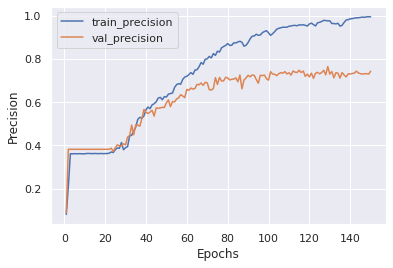

In [41]:
# 視覺化 Precision 結果
sns.set()
plt.plot(range(1, len(train_precision_list)+1), train_precision_list, label="train_precision")
plt.plot(range(1, len(val_precision_list)+1), val_precision_list, label="val_precision")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.show()

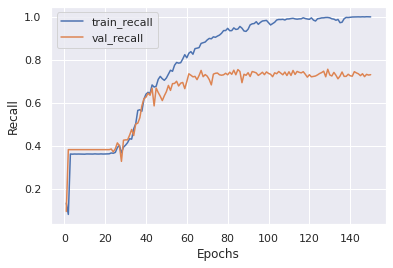

In [42]:
# 視覺化 Recall 結果
sns.set()
plt.plot(range(1, len(train_recall_list)+1), train_recall_list, label="train_recall")
plt.plot(range(1, len(val_recall_list)+1), val_recall_list, label="val_recall")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.show()

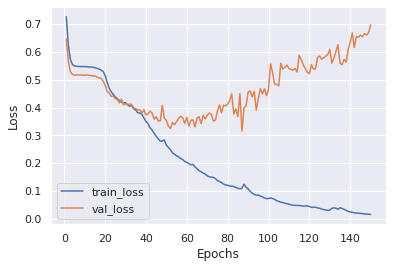

In [43]:
# 視覺化 Loss 結果
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label="train_loss")
plt.plot(range(1, len(val_loss_list)+1), val_loss_list, label="val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 驗證模型

In [44]:
model = Classifier()
model.load_state_dict(torch.load(config["model_path"]))

<All keys matched successfully>

In [45]:
def evaluate(model):
    model.eval()

    test_set = SDG_Dataset(val_df, val_embedding, label_list)

    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

    model = model.to(device)

    accuracy_list = []
    precision_list = []
    recall_list = []
    topk_recall_list = []
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():

        for test_embeddings, test_labels in test_loader:
            
            test_embeddings = test_embeddings.to(device)
            test_labels = test_labels.to(device)
            
            output = model(test_embeddings).cpu()

            pred = (output > 0).cpu()
            y_true = (test_labels > 0).cpu()
            
            # 計算評估指標
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"Top-5 Recall: {topk_recall}")
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)

            # 印出猜測的結果對應
            y_pred = list(label_list[pred[0]])
            y_true = list(label_list[y_true[0]])
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            # if not MLB.classes_[y_true[0]].any():
            print(f"預測: {y_pred}")
            print(f"正解: {y_true}")
            print("="*30)

    accuracy_res = np.array(accuracy_list).mean()
    precision_res = np.array(precision_list).mean()
    recall_res = np.array(recall_list).mean()
    topk_recall_res = np.array(topk_recall_list).mean()
    
    return accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list

In [46]:
accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list = evaluate(model)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3']
正解: ['SDG3']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4', 'SDG8']
正解: ['SDG4', 'SDG8']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG2']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3']
正解: ['SDG3']
Accuracy: 1.0
Precision:

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG4', 'SDG8']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3', 'SDG4', 'SDG8']
正解: ['SDG3']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3', 'SDG4', 'SDG8']
正解: ['SDG3', 'SDG4', 'SDG8']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4', 'SDG8', 'SDG11', 'SDG12']
正解: ['SDG4', 'SDG8', 'SDG11', 'SDG12']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4', 'SDG8']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3']
正解: ['SDG3']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4', 'SDG8']
正解: ['SDG4', 'SDG8']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['SDG4']
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG16']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 0.5
預測: ['SDG9', 'SDG11', 'SDG12', 'SDG13']
正解: ['SDG1', 'SDG10', 'SDG11', 'SDG12']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['SDG14']
正解: ['SDG4', 'SDG14']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['SDG4']
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 1.0
Recall: 0.8333333730697632
Top-5 Recall: 0.8333333730697632
預測: ['SDG4', 'SDG6', 'SDG12', 'SDG13', 'SDG15']
正解: ['SDG4', 'SDG6', 'SDG1

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['SDG4']
正解: ['SDG11', 'SDG12']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3']
正解: ['SDG3']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG3']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['SDG4']
正解: []
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4', 'SDG8']
Accuracy: 0.0
Precision: 0.5
Recall: 0.25
Top-5 Recall: 0.5
預測: ['SDG8', 'SDG16']
正解: ['SDG8', 'SDG9', 'SDG10', 'SDG12']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.83333337306976

Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['SDG4', 'SDG11']
正解: ['SDG4', 'SDG11', 'SDG12']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 1.0
預測: ['SDG3']
正解: ['SDG3', 'SDG4', 'SDG8']
Accuracy: 0.0
Precision: 0.5
Recall: 0.6666666865348816
Top-5 Recall: 0.6666666865348816
預測: ['SDG3', 'SDG4', 'SDG6', 'SDG12']
正解: ['SDG6', 'SDG12', 'SDG15']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3', 'SDG4', 'SDG8']
正解: ['SDG3', 'SDG4', 'SDG8']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['SDG11']
正解: ['SDG4']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4']
正解: ['SDG4']
Accuracy: 0.0
Precision: 0.5714285969734192
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG3', 'SDG4', 'SDG6', 'SDG7', 'SDG12', 'SDG13', 'SDG17']
正解: ['SDG4', 'S

In [47]:
f1_res = f1(precision_res, recall_res)

In [48]:
# 最終結果
print("Validation Data 結果:")
print(f"Accuracy: {accuracy_res: .3f}")
print(f"Precision: {precision_res: .3f}")
print(f"Recall: {recall_res: .3f}")
print(f"Top-5 Recall: {topk_recall_res: .3f}")
print(f"F1-score: {f1_res: .3f}")

Validation Data 結果:
Accuracy:  0.628
Precision:  0.766
Recall:  0.757
Top-5 Recall:  0.811
F1-score:  0.761


In [49]:
# 目前最佳結果
# Accuracy:  0.628
# Precision:  0.766
# Recall:  0.757
# Top-5 Recall:  0.811
# F1-score:  0.761